In [1]:

!pip install torch torchvision opencv-python scikit-learn matplotlib tqdm


In [2]:

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:

class UTKFaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        age = int(img_name.split('_')[0])
        if age < 10:
            age_class = 0
        elif age < 20:
            age_class = 1
        elif age < 40:
            age_class = 2
        elif age < 60:
            age_class = 3
        else:
            age_class = 4
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age_class)


In [4]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = UTKFaceDataset(r"D:\Swathi\UTK face\UTKFace", transform=transform)
small_dataset = Subset(dataset, list(range(0, 5000)))
train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_dataset, val_dataset = random_split(small_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

for epoch in range(10):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:51<00:00,  4.62s/it]


Epoch 1, Loss: 0.6298818328077831


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:36<00:00,  4.39s/it]


Epoch 2, Loss: 0.29940823808548944


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:36<00:00,  4.39s/it]


Epoch 3, Loss: 0.15251980302116228


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:17<00:00,  4.09s/it]


Epoch 4, Loss: 0.06772955566171616


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:12<00:00,  4.01s/it]


Epoch 5, Loss: 0.042463504960612644


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:13<00:00,  4.02s/it]


Epoch 6, Loss: 0.03032249535271336


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:11<00:00,  3.99s/it]


Epoch 7, Loss: 0.016798391620377228


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:24<00:00,  4.20s/it]


Epoch 8, Loss: 0.022241217900984107


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:16<00:00,  4.07s/it]


Epoch 9, Loss: 0.015487100529883589


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:28<00:00,  4.26s/it]

Epoch 10, Loss: 0.029329889712648258


MAE: 0.192
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       199
           1       0.69      0.77      0.73       317
           2       0.85      0.77      0.81       477
           4       0.80      0.57      0.67         7

    accuracy                           0.81      1000
   macro avg       0.82      0.78      0.80      1000
weighted avg       0.82      0.81      0.82      1000



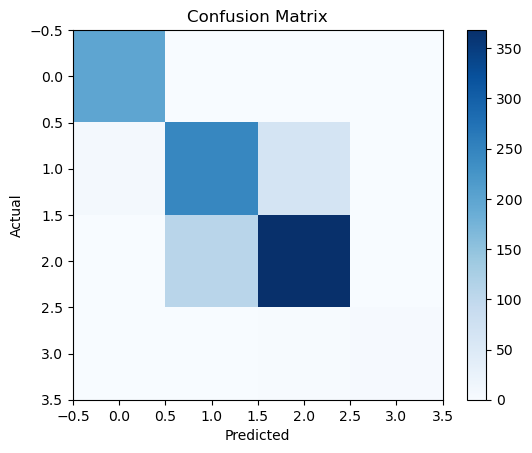

In [7]:

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

mae = mean_absolute_error(np.array(all_labels), np.array(all_preds))
print("MAE:", mae)
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


In [8]:

torch.save(model.state_dict(), "mobilenet_age_classifier_5bins.pth")


In [9]:

torch.save(model, "mobilenet_age_model_complete.pth")
